# SHL Grammar Scoring Engine - Model Development Notebook

Overview:
This notebook addresses the SHL Intern Hiring Assessment competition task of building a Grammar Scoring Engine. The goal is to predict MOS Likert Grammar Scores (0-5 range) based on spoken English audio samples. 

Approach:
1. Load and explore the dataset.
2. Extract features from .wav audio files (MFCC, Chroma, Spectral Contrast, Tonnetz).
3. Train a regression model (LightGBM) on the features.
4. Evaluate the model using RMSE and Pearson Correlation.
5. Predict on the test data and prepare a submission file.

Author: DHRUV JAIN
Date: 18-04-2025



In [ ]:

# Import required libraries
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import lightgbm as lgb
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



In [3]:
# 1. Load the dataset
train_df = pd.read_csv('D:/Interview Question/Dataset/train.csv')
test_df = pd.read_csv('D:/Interview Question/Dataset/test.csv')

# Define directories for audio files
train_audio_dir = 'D:/Interview Question/Dataset/audios/train'
test_audio_dir = 'D:/Interview Question/Dataset/audios/test'




In [4]:
# 2. Feature Extraction Function
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

    features = np.concatenate([
        np.mean(mfccs, axis=1),
        np.std(mfccs, axis=1),
        np.mean(chroma, axis=1),
        np.std(chroma, axis=1),
        np.mean(spectral_contrast, axis=1),
        np.std(spectral_contrast, axis=1),
        np.mean(tonnetz, axis=1),
        np.std(tonnetz, axis=1)
    ])
    return features



In [5]:
# 3. Extract features from training data
print("Extracting features from training data...")
features = []
labels = []
for i, row in train_df.iterrows():
    audio_path = os.path.join(train_audio_dir, row['filename'])
    if os.path.exists(audio_path):
        feat = extract_features(audio_path)
        features.append(feat)
        labels.append(row['label'])

X = np.array(features)
y = np.array(labels)



Extracting features from training data...


In [6]:
# 4. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [7]:
# 5. Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [17]:
# 6. Model Training - LightGBM Regressor
print("Training LightGBM model...")
model = lgb.LGBMRegressor(n_estimators=1000)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)




Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9069
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 76
[LightGBM] [Info] Start training from score 4.001408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

LGBMRegressor(n_estimators=1000)

In [18]:
# 7. Evaluation on validation set
y_pred_val = model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
pearson_corr_val, _ = pearsonr(y_val, y_pred_val)

print(f'Validation RMSE: {rmse_val:.4f}')
print(f'Validation Pearson Correlation: {pearson_corr_val:.4f}')



Validation RMSE: 0.9080
Validation Pearson Correlation: 0.6540


In [ ]:
# 8. Evaluation on training set
y_pred_train = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f'Training RMSE: {rmse_train:.4f}') 



Training RMSE: 0.3959


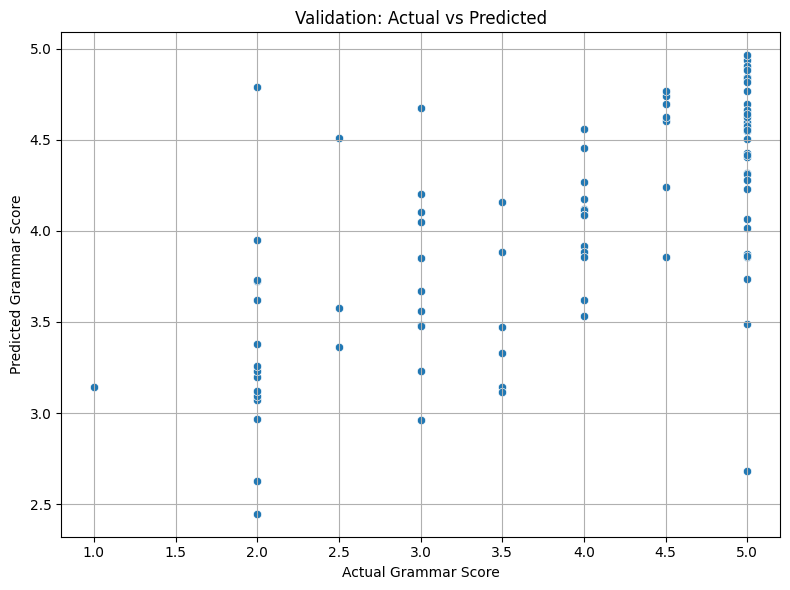

In [20]:
# 9. Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred_val)
plt.xlabel("Actual Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("Validation: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# 10. Extract features from test data
print("Extracting features from test data...")
test_features = []
for file_name in test_df['filename']:
    audio_path = os.path.join(test_audio_dir, file_name)
    if os.path.exists(audio_path):
        feat = extract_features(audio_path)
        test_features.append(feat)
    else:
        test_features.append(np.zeros_like(X[0]))  # placeholder for missing files

X_test = scaler.transform(test_features)



Extracting features from test data...


In [26]:
# 11. Make predictions on test set
y_test_pred = model.predict(X_test)



In [30]:
# 12. Prepare submission
submission = pd.DataFrame({
    'filename': test_df['filename'],
    'label': y_test_pred
})
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.
